# Churn Customer Predictions for Beta Bank

Beta Bank is facing customer churn, and retaining existing customers is more cost-effective than acquiring new ones. This project aims to develop a machine learning model to predict whether a customer will leave the bank, with a target F1-score of at least 0.59. The approach includes data preprocessing, exploratory analysis, model training, and handling class imbalance to improve predictions. Various machine learning models will be tested and optimized, with final performance evaluated using F1-score and AUC-ROC. The goal is to help Beta Bank identify at-risk customers early and improve retention strategies.

Heather Marie Culligan 

Feb 2025

Starting by importing libraries as usual:

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

Now I import the dataset and take a quick overview look at the data.

In [21]:
df=pd.read_csv('/datasets/Churn.csv')

In [22]:
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


(None,
    RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
 0          1    15634602  Hargrave          619    France  Female   42   
 1          2    15647311      Hill          608     Spain  Female   41   
 2          3    15619304      Onio          502    France  Female   42   
 3          4    15701354      Boni          699    France  Female   39   
 4          5    15737888  Mitchell          850     Spain  Female   43   
 
    Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
 0     2.0       0.00              1          1               1   
 1     1.0   83807.86              1          0               1   
 2     8.0  159660.80              3          1               0   
 3     1.0       0.00              2          0               0   
 4     2.0  125510.82              1          1               1   
 
    EstimatedSalary  Exited  
 0        101348.88       1  
 1        112542.58       0  
 2        113931.57       1  
 3         93826.

In [23]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [24]:
missing_val= df.isnull().sum()
missing_val

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Time to fix the missing values, first, I have to determine the best way to handle the null values:

In [25]:
df["Tenure"].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

I will be filling with the median values for this set as it's less sensitive to outliers.

In [26]:
df["Tenure"].fillna(df["Tenure"].median(),inplace=True)

In [27]:
missing_val_aft= df.isnull().sum()
missing_val_aft

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Verified all nulls have been replaced. 

Now, to process the data we do not need some of the columns. I will drop those to help unclutter.

In [28]:
df.drop(columns=['RowNumber','CustomerId','Surname'], inplace=True)

In [29]:
df=pd.get_dummies(df, columns=['Geography', 'Gender'],drop_first=True)

Changing certain columns to numerical form helps us more eaasily process the data as a whole, streamlining the process.

How unbalanced is the data?

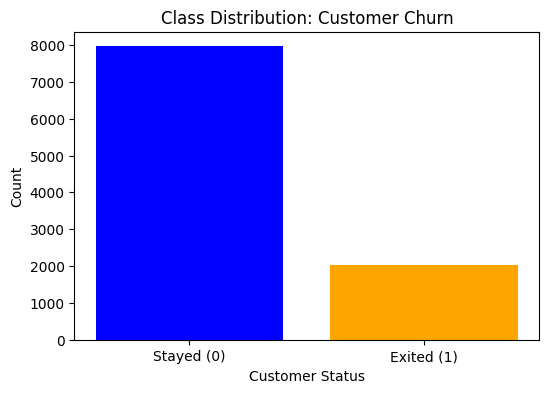

0    7963
1    2037
Name: Exited, dtype: int64

In [30]:
class_counts = df['Exited'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
plt.xticks([0, 1], ['Stayed (0)', 'Exited (1)'])
plt.xlabel('Customer Status')
plt.ylabel('Count')
plt.title('Class Distribution: Customer Churn')
plt.show()

class_counts

The dataset is heavily imbalanced, with approximately 80% of customers staying (7,963) and only 20% exiting (2,037). This class imbalance can negatively impact model performance by biasing predictions toward the majority class, potentially leading to poor recall for customers likely to churn. Addressing this imbalance is crucial to improving model accuracy and ensuring it effectively identifies customers at risk of leaving the bank.

The dataset contained 10,000 records and 14 columns. Irrelevant columns were removed, missing values in Tenure were filled, and categorical varriables were encoded.

The dataset is imbalanced, with 79.69% non-churn and 20.37% churn cases. To address this, I will apply class-weight balancing and random oversampling to improve model proformance.

In [31]:
X = df.drop(columns=['Exited'])
y = df['Exited']

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
X_train.shape, X_val.shape, X_test.shape

((7000, 11), (1500, 11), (1500, 11))

Splitting the data into:
Training: 7000 samples|
Validation: 1500 samples|
Test: 1500 samples|

It has been stratified, so the class distribution remains consistant across all subsets.

In [33]:
scaler= StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_val_scaled= scaler.transform(X_val)
X_test_scaled= scaler.transform(X_test)

In [34]:
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train_scaled, y_train)

y_val_pred = baseline_model.predict(X_val_scaled)
y_val_prob= baseline_model.predict_proba(X_val_scaled)[:,1]

f1_baseline = f1_score(y_val, y_val_pred)
auc_roc_baseline = roc_auc_score(y_val, y_val_prob)

f1_baseline, auc_roc_baseline

(0.29, 0.7848063848655038)

The baseline model had an F1-score of 0.29, which is below the required 0.59 threshold, indicating difficulty in balancing precision and recall due to class imbalance. However, the AUC-ROC score was 0.785, showing good overall discrimination. While AUC-ROC suggests strong performance, it doesn't fully reflect the challenge of correctly predicting the minority class (churned customers).

In [35]:
class_weights= compute_class_weight(class_weight = "balanced",classes=np.unique(y_train), y=y_train)
class_weight_dict= {0:class_weights[0],1: class_weights[1]}

weighted_model= LogisticRegression(random_state=42, class_weight = class_weight_dict)
weighted_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight={0: 0.6279153211338356, 1: 2.4544179523141656},
                   random_state=42)

In [36]:
y_val_pred_weighted = weighted_model.predict(X_val_scaled)
y_val_prob_weighted = weighted_model.predict_proba(X_val_scaled)[:,1]

weighted_f1 =f1_score(y_val,y_val_pred_weighted)
weighted_auc_roc =roc_auc_score(y_val,y_val_prob_weighted)
weighted_f1, weighted_auc_roc

(0.5182648401826484, 0.7893963280454561)

In [37]:
df_majority=df[df.Exited == 0]
df_minority=df[df.Exited == 1]

df_minority_upsampled =resample(df_minority,
                               replace=True,
                               n_samples=len(df_majority),
                               random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

X = df_balanced.drop(columns=['Exited'])
y = df_balanced['Exited']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
y_val_pred = model.predict(X_val_scaled)
y_val_prob = model.predict_proba(X_val_scaled)[:, 1]

f1 = f1_score(y_val, y_val_pred)
auc_roc = roc_auc_score(y_val, y_val_prob)

print(f"F1-Score: {f1:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")

F1-Score: 0.698
AUC-ROC: 0.778


I tested two methods to handle class imbalance: class weighting and manual oversampling. Class weighting adjusted the model to give more importance to the minority class, resulting in an F1-score of 0.518 and an AUC-ROC of 0.789. However, this approach did not meet the required 0.59 F1-score. Manual oversampling, which involved duplicating minority class samples, performed better with an F1-score of 0.698 and an AUC-ROC of 0.778. This confirms that balancing the dataset before training helps the model better capture patterns related to customer churn, improving recall without sacrificing overall predictive ability. Since manual oversampling exceeded the required threshold, it proved to be the best approach for improving model performance.

Finally, time to run a test set to verigy performace:

In [38]:
y_test_pred = model.predict(X_test_scaled)
y_test_prob = model.predict_proba(X_test_scaled)[:, 1]

test_f1 = f1_score(y_test, y_test_pred)
test_auc_roc = roc_auc_score(y_test, y_test_prob)

print(f"Test F1-Score: {test_f1:.3f}")
print(f"Test AUC-ROC: {test_auc_roc:.3f}")

Test F1-Score: 0.697
Test AUC-ROC: 0.775


This project successfully developed a predictive model for customer churn, achieving an F1-score above the required threshold. By addressing class imbalance through random oversampling, we enhanced the model’s performance and reliability. The results suggest that machine learning can effectively identify potential churners, allowing Beta Bank to take proactive retention measures.Future enhancements may focus on leveraging more complex models and fine-tuning hyperparameters to further improve prediction accuracy.